<a href="https://colab.research.google.com/github/neohack22/ethercourt/blob/master/pytorch_predict_buy_sell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Model

In [0]:
'''
Created using flowpoints.io

Link to model:
https://mariusbrataas.github.io/flowpoints_ml/?p=s3zqhawHSjTd

LICENSE:
https://github.com/mariusbrataas/flowpoints_ml/blob/master/LICENSE
'''


# Importing PyTorch tools
import torch, torchvision
from torch import nn, optim, cuda


# Importing other libraries
import numpy as np
import matplotlib.pyplot as plt
import time


# Seed
np.random.seed(1234)
torch.manual_seed(1234)
cuda.manual_seed(1234)
torch.backends.cudnn.deterministic = True


# Model
class NeuralNet(nn.Module):

    def __init__(self):

        # Basics
        super(NeuralNet, self).__init__()
        self.name        = 's3zqhawHSjTd'
        self.batch_first = True

        # Initializing all layers
        self.p_1 = nn.LSTM(
            input_size    = 6,
            hidden_size   = 64,
            num_layers    = 3,
            bias          = True,
            batch_first   = self.batch_first,
            dropout       = 0,
            bidirectional = False,
        )
        self.p_2 = nn.Linear(
            in_features  = 64,
            out_features = 3,
            bias         = True,
        )
        self.p_3 = nn.Sigmoid()

        # Running startup routines
        self.reset_hidden_states()


    def forward(self, p_0):
        p_0, self.p_1_hidden = self.p_1(p_0, tuple([_.data for _ in self.p_1_hidden]) if self.p_1_hidden else None) # LSTM
        p_0 = p_0.contiguous()     # Tensor transforms
        p_0 = self.p_2(p_0)        # Linear
        self.state = self.p_3(p_0) # Sigmoid
        return self.state


    def reset_hidden_states(self, sample=None):
        if type(sample) == torch.Tensor:
            batch_size = sample.shape[0 if self.batch_first else 1]
            self.p_1_hidden = (
                torch.zeros((3, batch_size, 64), device=sample.device), 
                torch.zeros((3, batch_size, 64), device=sample.device)
            )
        else:
            self.p_1_hidden = None


    def predict(self, p_0):
        device = next(self.parameters()).device # Current device
        self.eval()                             # Switch to eval mode
        with torch.no_grad():                   # Switch off autograd
            return self(p_0.to(device))



# Helper function for training model
def fit(model, train, test=None, epochs=10, optimizer=optim.Adam, criterion=nn.CrossEntropyLoss, lr=0.001, batch_size=32, shuffle=True, workers=4, progress=True):

    # Creating data loaders
    train_loader = torch.utils.data.DataLoader(
        train,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=workers
    )
    if test:
        test_loader = torch.utils.data.DataLoader(
            test,
            batch_size=batch_size,
            shuffle=False,
            num_workers=workers
        )
        best_loss = 1e6

    # Init optimizer and criterion
    optimizer = optimizer( model.parameters(), lr=lr )
    criterion = criterion()

    # Loss records
    train_loss_rec = []
    test_loss_rec = []

    # Device
    device = next(model.parameters()).device

    # Prep model
    model.train()

    # Showing progress?
    if progress:
        print(f'Running on {device}')
        epoch_l = max(2, len(str(epochs)))
        msg = '%sEpoch   Training loss' % ''.rjust(2 * epoch_l - 4, ' ')
        msg += ('   Testing loss   ' if test else '') + '   Time remaining'
        print(msg)
        t = time.time()

    # Gracefully interrupting training
    try:

        # Looping through epochs
        for epoch in range(epochs):

            # Reset epoch loss
            train_loss = 0
            test_loss = 0

            # Looping through training data
            for p_0, p_2 in train_loader:
                
                model.reset_hidden_states()

                # Prediction
                prediction = model( p_0.to(device) )

                # Loss
                loss = criterion( prediction, p_2.to(device) )
                train_loss += loss.item()

                # Backward pass and optimization
                loss.backward()       # Backward pass
                optimizer.step()      # Optimizing weights
                optimizer.zero_grad() # Clearing gradients

            # Adding loss to record
            train_loss_rec.append(train_loss / len(train))

            # Testing step
            if test:

                # Switching off autograd
                with torch.no_grad():

                    # Store all predictions and targets
                    all_predictions = []
                    all_targets = []

                    # Looping through testing data
                    for p_0, p_2 in test_loader:
                        
                        model.reset_hidden_states()

                        # Prediction
                        prediction = model( p_0.to(device) )

                        # Loss
                        loss = criterion( prediction, p_2.to(device) )
                        test_loss += loss.item()

                        # Appending predictions and targets
                        for pred, targ in zip(
                            prediction.cpu().detach().numpy().squeeze(),
                            p_2.cpu().detach().numpy().squeeze()
                        ):
                            all_predictions.append(pred.reshape(-1))
                            all_targets.append(targ.reshape(-1))

                    # Adding loss to record
                    test_loss_rec.append(test_loss / len(test))

                    # Saving best model?
                    if best_loss > test_loss_rec[-1]:
                        best_loss = test_loss_rec[-1]
                        torch.save(model.state_dict(), 'best_model.pth')

            # Showing progress?
            if progress:
                eta_s = ((time.time() - t) / (epoch + 1)) * (epochs - epoch - 1)
                msg = '%s/%s' % (str(epoch + 1).rjust(epoch_l, ' '), str(epochs).ljust(epoch_l, ' '))
                msg += ' | %s' % str(round(train_loss_rec[-1], 9)).ljust(13, ' ')
                if test: msg += ' | %s' % str(round(test_loss_rec[-1], 9)).ljust(15, ' ')
                msg += ' | '
                msg += '%sh ' % round(eta_s // 3600) if eta_s > 3600 else ''
                msg += '%sm ' % round(eta_s % 3600 // 60) if eta_s > 60 else ''
                msg += '%ss ' % round(eta_s % 60)
                print(msg)

    # Handling user interruption
    except KeyboardInterrupt:
        print('Gracefully interrupting training')
        model.eval()
        cuda.empty_cache()
        pass

    # Finish and return
    model.eval()
    return train_loss_rec, test_loss_rec

## Data handling

In [0]:
def onehot(feature, n=3):
    _out = np.zeros(n)
    _out[feature] = 1 if feature > 0 else 0.334
    return _out

class TSDS(torch.utils.data.Dataset):
    
    def __init__(self, inps, targs, seq_len=500):
        
        tot_len = (len(inps) // seq_len) * seq_len
        inps = inps[:tot_len]
        targs = targs[:tot_len]
        n_things = tot_len // seq_len
        self.X = [
            inps[idx * seq_len : (idx + 1) * seq_len]
            for idx in range(n_things)
        ]
        self.y = [
            targs[idx * seq_len : (idx + 1) * seq_len]
            for idx in range(n_things)
        ]
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        _X = self.X[idx]
        _y = self.y[idx]
        return torch.Tensor(_X), torch.Tensor(np.array([onehot(int(_)) for _ in _y]))

In [0]:
def trainTestSplit(_data, split=0.3):
    _train, _test = {}, {}
    for key in _data:
        tmp = data[key]
        idx = int(len(tmp) * (1 - split))
        _train[key] = tmp[:idx]
        _test[key] = tmp[idx:]
    return pd.DataFrame.from_dict(_train), pd.DataFrame.from_dict(_test)

def normalize(_data, window_size=48):
    window = _data[-window_size:]
    return (_data[-1] - np.mean(window, axis=0)) / (np.std(window, axis=0) + 1e-3)

def historyToTraining(_data, window_size=48):
    _data = np.array(_data, dtype=np.float32)
    _out = []
    for idx in range(20, len(_data)):
        _out.append(normalize(
            _data[:idx],
            window_size=window_size
        ))
    return np.nan_to_num(_out)

def getOptimal(_data, look_ahead=12):
    _data = np.array(_data['Close'], dtype=np.float32)
    buy_at = []
    sell_at = []
    l = len(_data)
    holding = False
    for idx in range(l-look_ahead):
        
        if _data[idx:idx+look_ahead].argmin() == 0:
            buy_at.append(idx)
        
        if _data[idx:idx+look_ahead].argmax() == 0:
            sell_at.append(idx)
    
    targs = np.zeros(l)
    for _ in buy_at:
        targs[_] = 1.0
    for _ in sell_at:
        targs[_] = 2.0
    return targs




data = pd.DataFrame.from_csv('ETHBTC.csv')

train, test = trainTestSplit(data)

X_train = historyToTraining(train)
y_train = getOptimal(train[20:])

X_test = historyToTraining(test)
y_test = getOptimal(test[20:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


## Initialize datasets

In [0]:
train_ds = TSDS(X_train, y_train)
test_ds = TSDS(X_test, y_test)

## Initialize model

In [0]:
model = NeuralNet()
model.cuda()

NeuralNet(
  (p_1): LSTM(6, 64, num_layers=3, batch_first=True)
  (p_2): Linear(in_features=64, out_features=3, bias=True)
  (p_3): Sigmoid()
)

In [0]:
z

## Train model!

In [0]:
# Main training
fit(
    model,
    train_ds,
    test=test_ds,
    epochs=500,
    optimizer=optim.Adam,
    criterion=nn.MSELoss,
    lr=0.0005,
    batch_size=32,
    shuffle=True,
    workers=2,
    progress=True
)

# Finetuning
fit(
    model,
    train_ds,
    test=test_ds,
    epochs=100,
    optimizer=optim.Adam,
    criterion=nn.MSELoss,
    lr=0.0001,
    batch_size=32,
    shuffle=True,
    workers=2,
    progress=True
)

Running on cuda:0
  Epoch   Training loss   Testing loss      Time remaining
  1/500 | 0.007694454   | 0.009105451     | 4m 16s 
  2/500 | 0.007599687   | 0.008979526     | 4m 12s 
  3/500 | 0.007484842   | 0.008844662     | 4m 4s 
  4/500 | 0.007366911   | 0.008696413     | 3m 59s 
  5/500 | 0.007245275   | 0.008529171     | 3m 56s 
  6/500 | 0.007098674   | 0.008335258     | 3m 53s 
  7/500 | 0.006933089   | 0.008104263     | 3m 50s 
  8/500 | 0.006748545   | 0.007822243     | 3m 48s 
  9/500 | 0.006499096   | 0.00747089      | 3m 47s 
 10/500 | 0.006185871   | 0.007030164     | 3m 45s 
 11/500 | 0.005790693   | 0.006494542     | 3m 43s 
 12/500 | 0.005352747   | 0.005919041     | 3m 43s 
 13/500 | 0.00489919    | 0.005458329     | 3m 41s 
 14/500 | 0.004567302   | 0.005234309     | 3m 40s 
 15/500 | 0.004418441   | 0.005185948     | 3m 39s 
 16/500 | 0.004425402   | 0.005200548     | 3m 39s 
 17/500 | 0.00443053    | 0.005219546     | 3m 37s 
 18/500 | 0.004438609   | 0.00522411    

([0.00422829653446873,
  0.004227797190348308,
  0.004213392113645871,
  0.00423994396502773,
  0.004247903202970822,
  0.004218345507979393,
  0.004232667696972688,
  0.00422486833607157,
  0.004223282293727,
  0.00422024168074131,
  0.004226710647344589,
  0.004195884025345246,
  0.004233879037201405,
  0.004234390643735726,
  0.004213069720814626,
  0.0042174761183559895,
  0.004223126297195752,
  0.004206775066753228,
  0.00418008491396904,
  0.004224014313270648,
  0.004198990607013305,
  0.004227785859256983,
  0.0042137261480093,
  0.004192516673356295,
  0.004234901629388332,
  0.004208623586843411,
  0.00421352048094074,
  0.004203448382516702,
  0.004200706258416176,
  0.004234255446741979,
  0.004185499002536138,
  0.004223777912557125,
  0.004211352361987035,
  0.004197222646325827,
  0.004237919424970944,
  0.0042036583957572775,
  0.004224961002667745,
  0.004207674879580736,
  0.0042230295948684216,
  0.004223702785869439,
  0.0042055225931108,
  0.004223544616252184,
  

## Helper for testing our model

In [0]:
def test_and_plot(model, _data, prices, buy_threshold=0.2, sell_threshold=0.25):
    
    # Make sure prices is a numpy array
    prices = np.array(prices, dtype=np.float32)
    
    # Reset model
    model.reset_hidden_states()
    
    # Run inference
    predictions = model.predict(torch.Tensor(_data).view(1, len(_data), 6))
    
    # Prep and reshape predictions
    predictions = predictions.cpu().detach()
    predictions = predictions.numpy().squeeze()
    
    # Flag all buy and sell points
    buy_x, buy_y = [], []
    sell_x, sell_y = [], []
    
    for idx in range(len(predictions)):
        buy = predictions[idx][1]
        sell = predictions[idx][2]
        if buy > buy_threshold and buy > sell:
            buy_x.append(idx)
            buy_y.append(prices[idx])
        elif sell > sell_threshold and sell > buy:
            sell_x.append(idx)
            sell_y.append(prices[idx])
    
    # Plot results
    plt.figure(figsize=(25,15))
    plt.plot(prices, label='Price')
    plt.scatter(buy_x, buy_y, color='green', label='Buy')
    plt.scatter(sell_x, sell_y, color='red', label='Sell')
    plt.show()

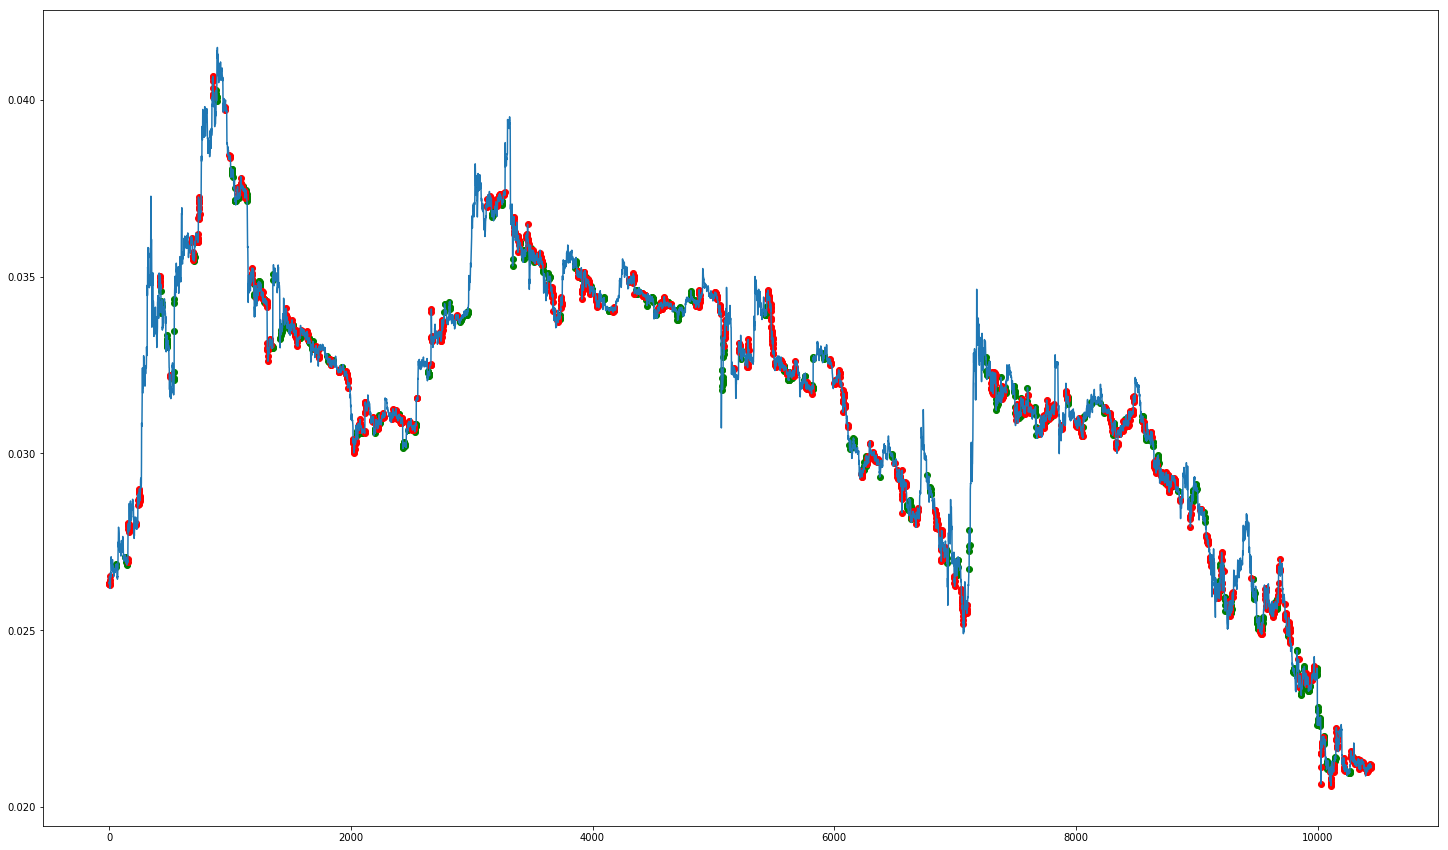

In [0]:
test_and_plot(model, X_test, test['Close'][20:])

## Saving and loading

In [0]:
    # Uncomment and run the following code to save your model
torch.save(model.state_dict(), 'pytorch_buy_sell_model.pth')

In [0]:
# Uncomment and run the following code to load a model
#model = NeuralNet()
#model.load_state_dict(torch.load('pytorch_buy_sell_model.pth'))